# Подготовка данных

In [1]:
import numpy as np
import pandas as pd

from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

from collections import Counter

In [2]:
repetitors = pd.read_csv('repetitors.csv', sep=',')
repetitors[:2]

,price_avg,mark,review_count,descr_preproc,msk,beginner,middle,expert,math,hum,language,elementary
0,1700.0,0.00,0.0,чжу юцзить проводить дистанционный китайский о...,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1,866.0,4.67,3.0,ошлыковый ольга борисович литература образован...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0


## Составление словаря

In [312]:
text = ' '.join(repetitors['descr_preproc'])
list_of_words = text.split()
dictionary = Counter(list_of_words)

In [313]:
dictionary.most_common(10)

[('опыт', 88831),
 ('образование', 80157),
 ('английский', 79618),
 ('факультет', 69007),
 ('специальность', 56730),
 ('выезд', 55417),
 ('школа', 53795),
 ('университет', 44610),
 ('проводить', 43720),
 ('дистанционный', 40682)]

In [314]:
len(dictionary)

65607

(-0.5, 399.5, 199.5, -0.5)

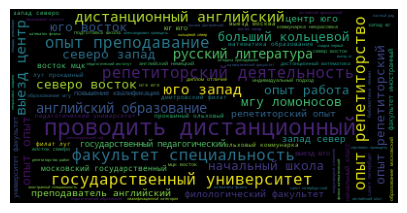

In [137]:
cloud = WordCloud().generate(' '.join(repetitors['descr_preproc']))
plt.imshow(cloud)
plt.axis('off')

# Обучение

## Подключаем библиотеки

In [20]:
# !pip install catboost

In [5]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
import lightgbm as lgb
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn import svm

from sklearn.metrics import mean_squared_error, mean_absolute_error,  make_scorer
from sklearn.metrics import mean_absolute_percentage_error, median_absolute_error, r2_score

## Векторизация - мешок слов

In [6]:
vectorizer = CountVectorizer(max_features=3000)
count_v = vectorizer.fit_transform(repetitors['descr_preproc'])
vectorized_df = pd.DataFrame(count_v.toarray(), columns=vectorizer.get_feature_names_out())
repetitors_without = repetitors.drop('descr_preproc',axis=1)
merged_df = pd.concat([repetitors_without, vectorized_df], axis=1)
X = merged_df.iloc[:, 1:]
y = merged_df['price_avg']

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train.shape, X_test.shape

((61790, 3010), (15448, 3010))

In [8]:
# Функция дл построения и обучения модели

def model_score(model, criterion):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    if 'mean_squared_error' in str(criterion):
        return round(np.sqrt(criterion(y_test,y_pred)),2)
    else: return round(criterion(y_test,y_pred),2)

In [9]:
model_name = ['LinearRegression','Ridge','Lasso',
              'DecisionTreeRegressor','RandomForestRegressor',
              'LGBMRegressor','CatBoostRegressor', 'GradientBoostingRegressor']
models = [LinearRegression(), Ridge(), Lasso(),
          DecisionTreeRegressor(random_state=42, min_samples_split = 8,
                           min_samples_leaf = 9, max_features = 1.0,
                           max_depth = 7, ccp_alpha = 0.5), 
          RandomForestRegressor(n_estimators =  100, min_samples_split = 8,
                           min_samples_leaf = 9, max_features = 1.0,
                           max_depth = 7), 
          LGBMRegressor(), CatBoostRegressor(verbose = False), GradientBoostingRegressor()]

model_result = {}

quality = [mean_squared_error,
           mean_absolute_error,
           r2_score]

In [10]:
for i in range(len(models)):
    model_result[model_name[i]] = [model_score(models[i],q) for q in quality]
        
results = pd.DataFrame(model_result, index = ['RMSE', 'MAE', 'R2'])

In [11]:
results

,LinearRegression,Ridge,Lasso,DecisionTreeRegressor,RandomForestRegressor,LGBMRegressor,CatBoostRegressor,GradientBoostingRegressor
RMSE,295.71,295.50,295.34,303.80,299.38,283.44,283.07,291.29
MAE,230.17,230.04,230.95,237.60,234.48,220.17,219.42,228.05
R2,0.34,0.34,0.35,0.31,0.33,0.40,0.40,0.36


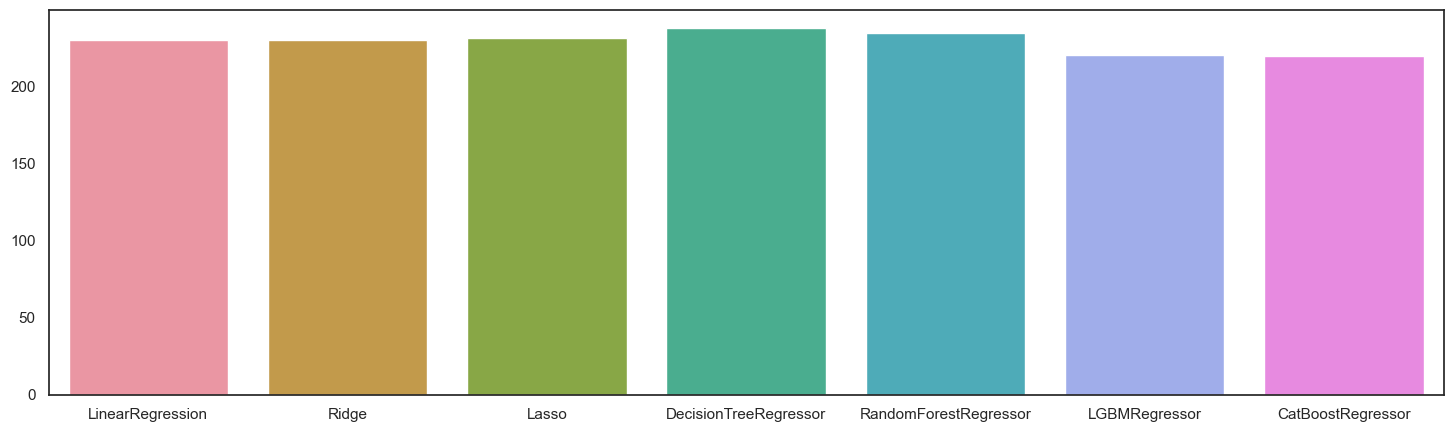

In [27]:
%matplotlib inline
plt.figure(figsize=(18,5))
sns.barplot(x = ['LinearRegression','Ridge','Lasso',
              'DecisionTreeRegressor','RandomForestRegressor',
              'LGBMRegressor','CatBoostRegressor'], 
            y = results[1:2].values.tolist()[0][:-1])
plt.show()

### Отдельно рассмотрим самую лучшую модель

In [29]:
model = CatBoostRegressor(verbose = False)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

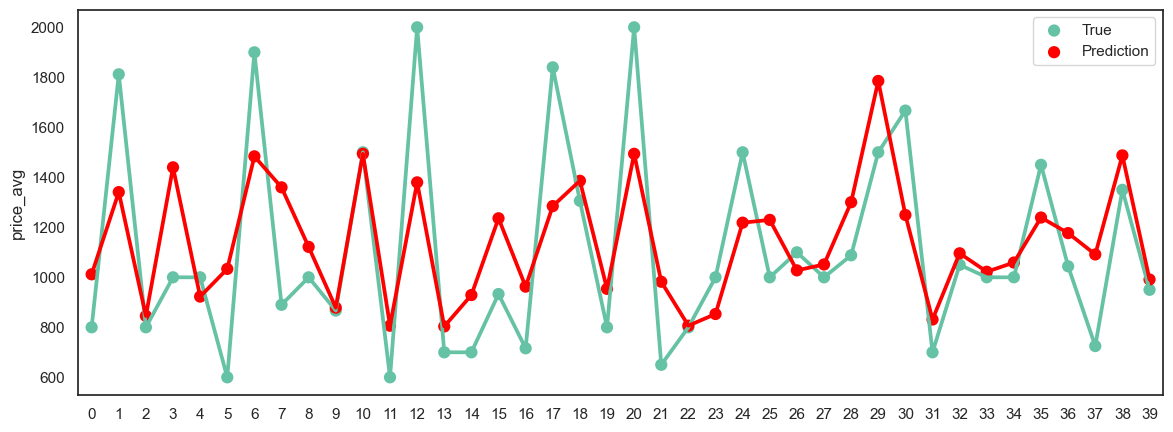

In [30]:
sns.set_theme(style="white", palette='Set2',rc={"figure.figsize":(14,5)})
g = sns.pointplot(x=y_test.index[:40], y=y_test[:40], label='True')
g = sns.pointplot(x=y_test.index[:40], y=y_pred[:40], color='red', label='Prediction')
g.set_xticklabels(np.arange(40))
plt.legend()
plt.show()

#### Важность признаков

In [31]:
feature_importance = model.get_feature_importance()
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importance})

In [32]:
feature_importance_df.sort_values(by='Importance', ascending=False)[:10]

,Feature,Importance
2,msk,15.861391
1,review_count,13.106273
3,beginner,7.545511
0,mark,6.646167
588,дистанционный,3.402010
5,expert,2.472118
743,запад,1.687227
642,достижение,1.413698
1255,мгу,1.332739
2021,проводить,1.328740


#### Сильные отклонения (более чем в 500 рублей)

In [33]:
list_inx = []
list_values = []

for i in range(len(y_test)):
    if np.abs(y_test.to_numpy()[i] - y_pred[i]) > 500:
        list_inx.append(y_test.index[i])
        list_values.append(round(y_pred[i]))


comparison = repetitors.loc[list_inx]
comparison.loc[:, 'y_pred'] = list_values

In [67]:
# Когда модель предсказала больше
comparison[comparison['y_pred'] > comparison['price_avg']].sort_values(by='msk')[2:10]

,price_avg,mark,review_count,descr_preproc,msk,beginner,middle,expert,math,hum,language,elementary,y_pred
2267,575.0,4.97,30.0,костров маргарита александрович проводить дист...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1189
66146,566.0,4.82,50.0,черкашин виталий вячеславович проводить дистан...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1249
57275,605.0,4.90,41.0,май малюк дмитрий владимирович проводить диста...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1265
28938,650.0,4.90,21.0,шумкий елена сергеевич проводить дистанционный...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1193
26551,1066.0,5.00,17.0,мормиля анастасия константинович проводить дис...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1806
37957,700.0,0.00,0.0,воробьёв дарья михаилович английский коучий об...,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1239
251,833.0,0.00,0.0,белкин юлия александрович проводить дистанцион...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1445
63761,672.0,5.00,1.0,гайдарбеков диана магомедович проводить дистан...,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1414


In [60]:
# Когда модель предсказала меньше
comparison[comparison['y_pred'] < comparison['price_avg']][900:906]

,price_avg,mark,review_count,descr_preproc,msk,beginner,middle,expert,math,hum,language,elementary,y_pred
46948,1500.0,0.00,0.0,проводить дистанционный испанский носитель исп...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,875
75320,1700.0,4.25,4.0,умникова елена андреевич математика образовани...,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,870
42936,2000.0,4.84,50.0,корольков ольга владимирович проводить дистанц...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1455
46431,2000.0,4.88,16.0,кастро аревало эдвин хавьер проводить дистанци...,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1252
8420,1750.0,4.78,36.0,тарзиманов гульшат джавадович проводить дистан...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1097
17358,2000.0,4.50,2.0,кудряшов ирина александрович математик програм...,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1077


#### Построим гистограмму ошибок

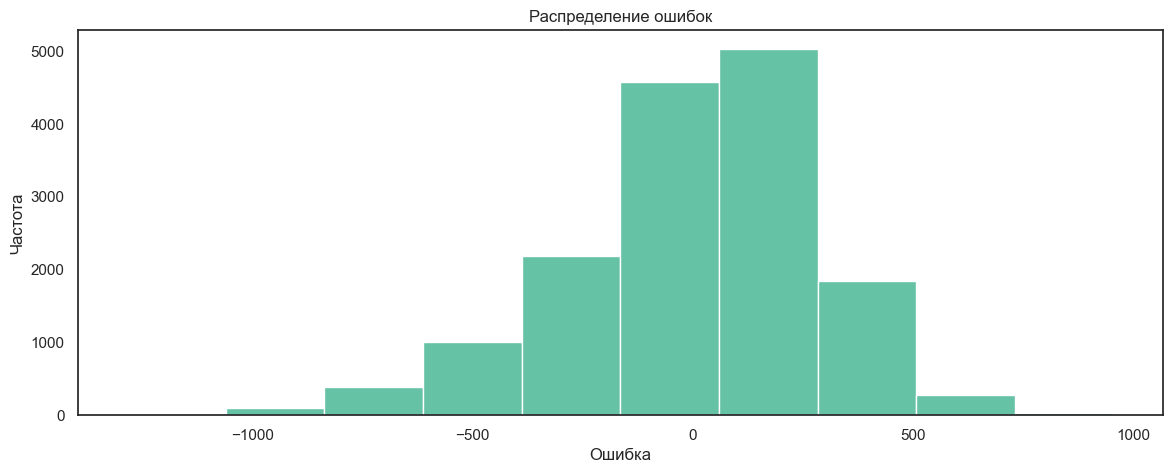

In [68]:
sns.set_theme(style="white", palette='Set2',rc={"figure.figsize":(14,5)})
errors = [predicted - real for predicted, real in zip(y_pred, y_test.to_numpy())]

# Построение графика распределения ошибок
plt.hist(errors, bins=10)
plt.xlabel('Ошибка')
plt.ylabel('Частота')
plt.title('Распределение ошибок')
plt.show()

## Векторизация - TF-IDF

In [281]:
vectorizer = TfidfVectorizer(max_features=3000)
tfidf = vectorizer.fit_transform(repetitors['descr_preproc'])
vectorized_df = pd.DataFrame(tfidf.toarray(), columns=vectorizer.get_feature_names_out())
repetitors_without = repetitors.drop('descr_preproc',axis=1)
merged_df = pd.concat([repetitors_without, vectorized_df], axis=1)
X = merged_df.iloc[:, 1:]
y = merged_df['price_avg']

In [283]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train.shape, X_test.shape

((61790, 3010), (15448, 3010))

In [295]:
for i in range(len(models)):
    model_result[model_name[i]] = [model_score(models[i],q) for q in quality]
        
results_tfidf = pd.DataFrame(model_result, index = ['RMSE', 'MAE', 'R2'])

In [296]:
results_tfidf

,LinearRegression,Ridge,Lasso,DecisionTreeRegressor,RandomForestRegressor,LGBMRegressor,CatBoostRegressor,GradientBoostingRegressor
RMSE,292.76,290.84,311.51,304.22,299.13,284.00,283.59,290.94
MAE,228.74,227.42,245.42,237.44,234.28,220.99,220.43,227.97
R2,0.37,0.37,0.28,0.31,0.34,0.40,0.40,0.37


### Отдельно рассмотрим самую лучшую модель

In [285]:
model = CatBoostRegressor(verbose = False)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_pred = np.clip(y_pred, 500, 2000)

feature_importance = model.get_feature_importance()
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importance})

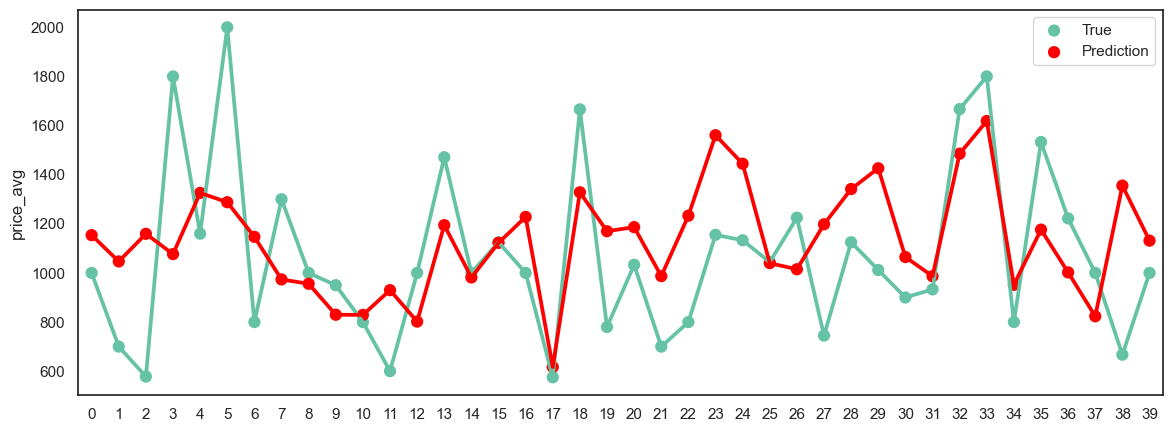

In [294]:
sns.set_theme(style="white", palette='Set2',rc={"figure.figsize":(14,5)})
g = sns.pointplot(x=y_test.index[:40], y=y_test[:40], label='True')
g = sns.pointplot(x=y_test.index[:40], y=y_pred[:40], color='red', label='Prediction')
g.set_xticklabels(np.arange(40))
plt.legend()
plt.show()

In [293]:
feature_importance_df.sort_values(by='Importance', ascending=False)[:10]

,Feature,Importance
2,msk,15.743303
1,review_count,12.225550
3,beginner,7.727299
0,mark,6.450550
388,выезд,4.172142
5,expert,2.395741
588,дистанционный,2.367008
743,запад,1.786021
2021,проводить,1.598899
1255,мгу,1.323892


# Подбор параметров 

In [69]:
import sklearn
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from scipy.stats import randint

In [83]:
vectorizer = CountVectorizer(max_features=3000)
count_v = vectorizer.fit_transform(repetitors['descr_preproc'])
vectorized_df = pd.DataFrame(count_v.toarray(), columns=vectorizer.get_feature_names_out())
repetitors_without = repetitors.drop('descr_preproc',axis=1)
merged_df = pd.concat([repetitors_without, vectorized_df], axis=1)
X = merged_df.iloc[:, 1:]
y = merged_df['price_avg']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train.shape, X_test.shape

((61790, 3010), (15448, 3010))

## DecisionTreeRegressor

In [84]:
dt = DecisionTreeRegressor()
mse = make_scorer(mean_squared_error)

# Задаем сетку параметров для перебора
param_dist = {'max_depth': np.arange(2, 30),
              'max_features': [1.0, 'sqrt', 'log2', None],
              'min_samples_split': np.arange(2, 10),
              'min_samples_leaf': np.arange(1, 10)}

# Задаем RandomizedSearchCV
dt_cv = RandomizedSearchCV(estimator=rf, 
                           param_distributions=param_dist, 
                           n_iter=10, 
                           scoring=mse,
                           cv=3, 
                           random_state=42,
                           n_jobs=-1)

# Обучаем модель
dt_cv.fit(X_train, y_train)
print("Лучшие параметры:", dt_cv.best_params_)

Лучшие параметры: {'min_samples_split': 6, 'min_samples_leaf': 9, 'max_features': None, 'max_depth': 8}


In [84]:
model = DecisionTreeRegressor(random_state=42, min_samples_split = 6,
                           min_samples_leaf = 9, max_features = None,
                           max_depth = 8)
model.fit(X_train, y_train)
y_pred_dtr = model.predict(X_test)

In [86]:
round(mean_absolute_error(y_test,y_pred_dtr),2)

234.39

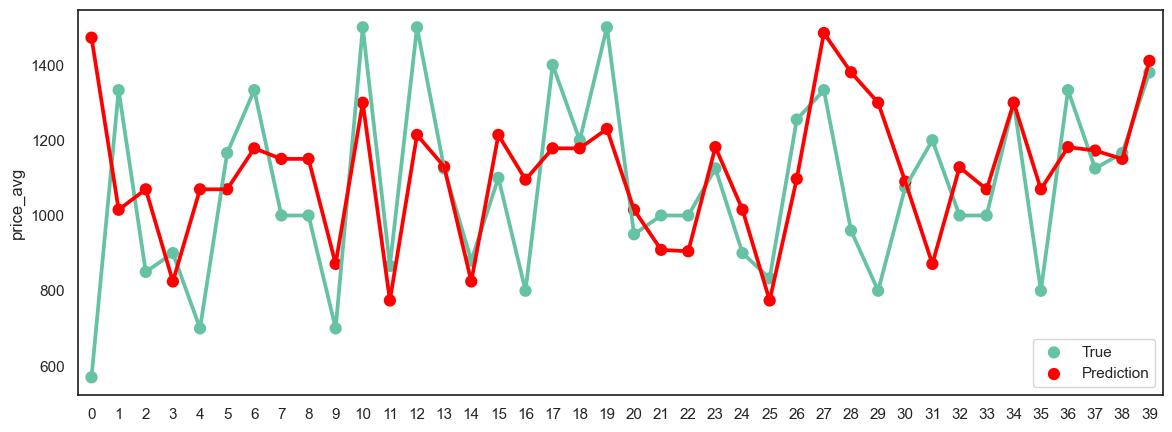

In [87]:
sns.set_theme(style="white", palette='Set2',rc={"figure.figsize":(14,5)})
g = sns.pointplot(x=y_test.index[:40], y=y_test[:40], label='True')
g = sns.pointplot(x=y_test.index[:40], y=y_pred_dtr[:40], color='red', label='Prediction')
g.set_xticklabels(np.arange(40))
plt.legend()
plt.show()

#### Важные признаки

In [93]:
importance = model.feature_importances_

feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': importance})
feature_importance_df.sort_values(by='Importance', ascending=False)[:20]

,Feature,Importance
1,review_count,0.433376
2,msk,0.203888
3,beginner,0.128384
0,mark,0.069099
588,дистанционный,0.068955
5,expert,0.014828
2273,санкт,0.014729
4,middle,0.008948
743,запад,0.008931
642,достижение,0.008119


## RandomForestRegressor

In [82]:
rf = RandomForestRegressor()
mse = make_scorer(mean_squared_error)

# Задаем сетку параметров для перебора
param_dist = {'n_estimators': randint(400, 700),
              'max_depth': randint(5, 50),
              'max_features': [1.0, 'sqrt', 'log2', None],
              'min_samples_split': randint(2, 10),
              'min_samples_leaf': randint(1, 10)}

rs_cv = RandomizedSearchCV(estimator=rf, 
                           param_distributions=param_dist, 
                           n_iter=10, 
                           scoring=mse,
                           cv=3, 
                           random_state=42,
                           n_jobs=-1)

rs_cv.fit(X_train, y_train)
print("Лучшие параметры:", rs_cv.best_params_)

Лучшие параметры: {'n_estimators': 700, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'log2', 'max_depth': 13}


In [88]:
y_pred_rf = rs_cv.predict(X_test)
round(mean_absolute_error(y_test,y_pred_rf),2)

234.20


## CatBoostRegressor

In [54]:
from scipy.stats import uniform

# Задаем параметры для подбора
param_grid = {
    'learning_rate': [0.1, 0.3],
    'depth': [3, 5, 7],
    'l2_leaf_reg': uniform(0, 10),
    'iterations': [200, 300]
}


model = CatBoostRegressor(verbose = False)

cbr_random = RandomizedSearchCV(model, 
                                param_distributions=param_grid, 
                                n_iter=10, 
                                cv=5, 
                                scoring='neg_mean_squared_error')

cbr_random.fit(X_train, y_train)

print("Best parameters: ", cbr_random.best_params_)
print("Best MSE: ", -cbr_random.best_score_)

Best parameters:  {'depth': 7, 'iterations': 300, 'l2_leaf_reg': 4.869173903985031, 'learning_rate': 0.3}
Best MSE:  81428.33202366313


In [55]:
model = CatBoostRegressor(**cbr_random.best_params_, verbose = False)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [91]:
print(round(mean_absolute_error(y_test,y_pred),1))

218.0


In [58]:
feature_importance = model.get_feature_importance()
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importance})

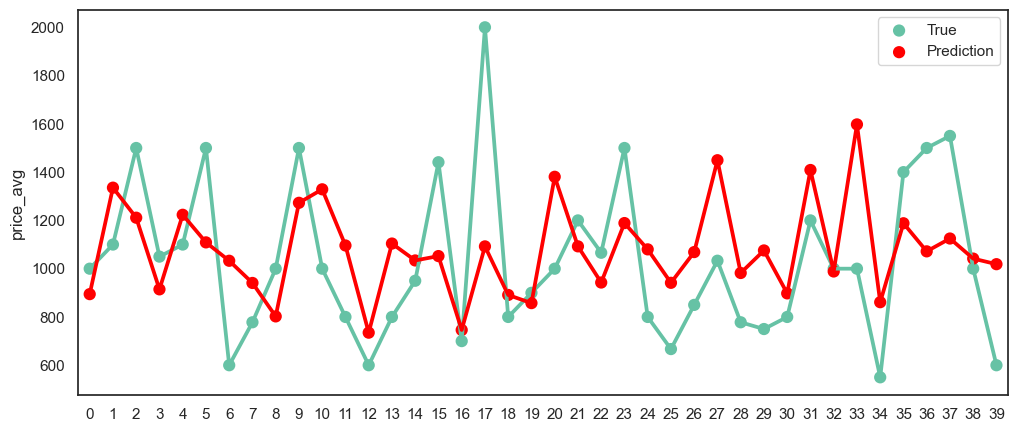

In [57]:
sns.set_theme(style="white", palette='Set2',rc={"figure.figsize":(12,5)})
g = sns.pointplot(x=y_test.index[:40], y=y_test[:40], label='True')
g = sns.pointplot(x=y_test.index[:40], y=y_pred[:40], color='red', label='Prediction')
g.set_xticklabels(np.arange(40))
plt.legend()
plt.show()

## VotingRegressor

In [37]:
from sklearn.ensemble import VotingRegressor

In [39]:
# Создаем объект VotingRegressor, объединяющий модели
vr = VotingRegressor([('LGBMRegressor', LGBMRegressor()), 
                      ('CatBoostRegressor', CatBoostRegressor(verbose = False))])

vr.fit(X_train, y_train)
y_pred_voit = vr.predict(X_test)
mean_absolute_error(y_test,y_pred)

219.42584631237276

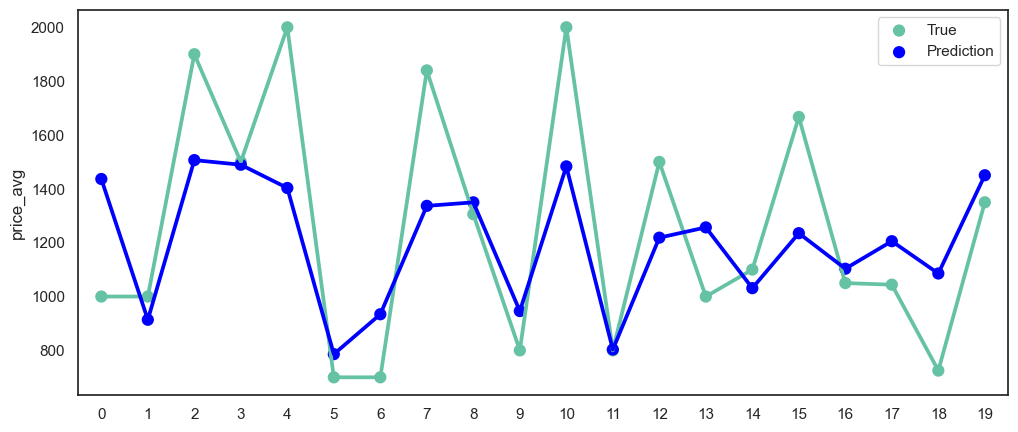

In [94]:
sns.set_theme(style="white", palette='Set2',rc={"figure.figsize":(12,5)})
g = sns.pointplot(x=y_test.index[:20], y=y_test[:20], label='True')
g = sns.pointplot(x=y_test.index[:20], y=y_pred_voit[:20], color='blue', label='Prediction')
g.set_xticklabels(np.arange(20))
plt.legend()
plt.show()

In [98]:
list_inx_voting = []
list_values_voting = []

for i in range(len(y_test)):
    if np.abs(y_test.to_numpy()[i] - y_pred_voit[i]) > 500:
        list_inx_voting.append(y_test.index[i])
        list_values_voting.append(round(y_pred_voit[i]))


comparison = repetitors.loc[list_inx_voting]
comparison.loc[:, 'y_pred_voit'] = list_values_voting

In [115]:
# Когда модель предсказала больше
comparison[comparison['y_pred_voit'] > comparison['price_avg']].sort_values(by='msk')[5:10]

,price_avg,mark,review_count,descr_preproc,msk,beginner,middle,expert,math,hum,language,elementary,y_pred_voit
28938,650.0,4.90,21.0,шумкий елена сергеевич проводить дистанционный...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1180
12195,646.0,4.78,36.0,анпилов екатерина сергеевич проводить дистанци...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1158
15889,850.0,4.89,50.0,соколов владимир сергеевич проводить дистанцио...,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1722
4075,700.0,5.00,3.0,осипов юрий валентинович проводить дистанционн...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1332
52705,780.0,4.67,9.0,жарков наталья сергеевич проводить дистанционн...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1440


In [121]:
# Когда модель предсказала меньше
comparison[comparison['y_pred_voit'] < comparison['price_avg']].sort_values(by='msk')[85:92]

,price_avg,mark,review_count,descr_preproc,msk,beginner,middle,expert,math,hum,language,elementary,y_pred_voit
53412,1766.0,4.92,12.0,великанов наталья владимирович проводить диста...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1175
76500,1500.0,4.77,13.0,локоток сергей александрович проводить дистанц...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,903
19947,1500.0,4.80,5.0,воеводин ирина валериевич проводить дистанцион...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,929
1472,2000.0,5.00,2.0,букин дарья владимирович проводить дистанционн...,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1326
42074,2000.0,5.00,1.0,чигрять андрей василиевич проводить дистанцион...,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1406
18384,1950.0,5.00,12.0,солохина наталья николаевич проводить дистанци...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1394
52927,2000.0,4.94,16.0,кладовый ксения николаевич проводить дистанцио...,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1459
